**Goal**  
Use the feature matrix from `feature_engineering.ipynb` to predict the most recent inspection score (`last_score`) and see which factors seem most important.

**Plan**
1. Load the train/test splits.
2. Fit a simple baseline model that always predicts the mean score.
3. Fit a decision tree regression model using the numeric and encoded categorical features.
4. Compare mean squared error (MSE) and \(R^2\) on the test set.
5. Inspect feature importances and a predicted vs actual plot.

In [2]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Load feature matrix and targets created in feature_engineering.ipynb
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze("columns")
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze("columns")

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((21257, 8), (5315, 8), (21257,), (5315,))

In [3]:
X_train.head()


,BORO,ZIPCODE,CUISINE_DESCRIPTION,num_inspections,crimes_nearby,property_yearbuilt,property_assesstot,property_landuse
0,2,142,22,8,45952,2005.0,3295800.0,5
1,1,59,33,15,26224,1925.0,370800.0,5
2,2,148,73,5,39712,1940.0,7974450.0,4
3,1,41,19,24,8886,1931.0,378900.0,5
4,1,37,86,14,18104,1950.0,130260.0,5


### Baseline model: always predict the mean score

As a baseline, We can first use a simple model that always predicts the mean training score for every restaurant. This gives a reference MSE and \(R^2\).


In [6]:
y_mean = y_train.mean()

y_pred_baseline = np.full_like(y_test, fill_value=y_mean, dtype=float)

baseline_mse = mean_squared_error(y_test, y_pred_baseline)
baseline_r2  = r2_score(y_test, y_pred_baseline)

baseline_mse, baseline_r2


(255.17963438438022, -4.0392283649381966e-05)

We need to make sure there are no NaN values before we make the model.

In [ ]:

print("Missing in y_train:", y_train.isna().sum())
print("Missing in y_test:", y_test.isna().sum())


Missing in y_train: 5
Missing in y_test: 0


There are very few NaN values, so we can drop them

In [10]:
mask_train = ~y_train.isna()
X_train = X_train[mask_train].copy()
y_train = y_train[mask_train].copy()

mask_test = ~y_test.isna()
X_test = X_test[mask_test].copy()
y_test = y_test[mask_test].copy()


### Decision tree regression

Next, we can fit a decision tree regressor on the same training data.  
The inputs are the numeric and encoded categorical features from the feature engineering step, and the target is `last_score`.


In [11]:
tree = DecisionTreeRegressor(
    max_depth=6,
    random_state=42
)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

tree_mse = mean_squared_error(y_test, y_pred_tree)
tree_r2  = r2_score(y_test, y_pred_tree)

tree_mse, tree_r2


(192.06649594088606, 0.24729787152235727)

### Model comparison 

We can compare the baseline and decision tree models using mean squared error (MSE) and \(R^2\) on the test set.


In [12]:
results = pd.DataFrame({
    "model": ["Baseline (mean)", "DecisionTreeRegressor"],
    "MSE":   [baseline_mse,       tree_mse],
    "R2":    [baseline_r2,        tree_r2]
})

results


,model,MSE,R2
0,Baseline (mean),255.179634,-0.000040
1,DecisionTreeRegressor,192.066496,0.247298


### Predicted vs actual scores

To see how the model behaves, We can plot the predicted scores against the true scores for the test set.


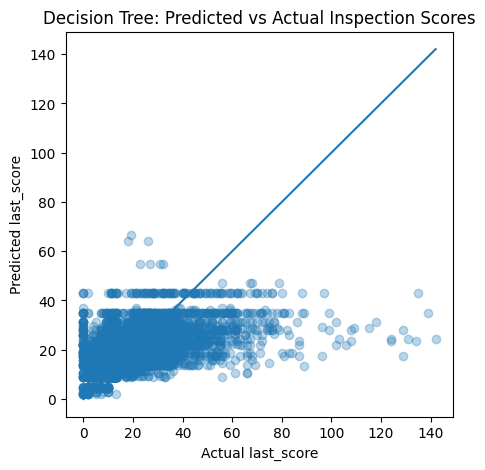

In [13]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred_tree, alpha=0.3)
plt.xlabel("Actual last_score")
plt.ylabel("Predicted last_score")
plt.title("Decision Tree: Predicted vs Actual Inspection Scores")

# 45-degree line for reference
min_val = min(y_test.min(), y_pred_tree.min())
max_val = max(y_test.max(), y_pred_tree.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.show()


### Feature importances

Finally, We can look at the decision tree feature importances to see which variables the model relied on most when predicting inspection scores.


In [14]:
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": tree.feature_importances_
})

importances_sorted = importances.sort_values("importance", ascending=False)
importances_sorted.head(15)


,feature,importance
3,num_inspections,0.927683
2,CUISINE_DESCRIPTION,0.023070
4,crimes_nearby,0.022066
6,property_assesstot,0.008414
1,ZIPCODE,0.006785
5,property_yearbuilt,0.005251
7,property_landuse,0.003631
0,BORO,0.003101


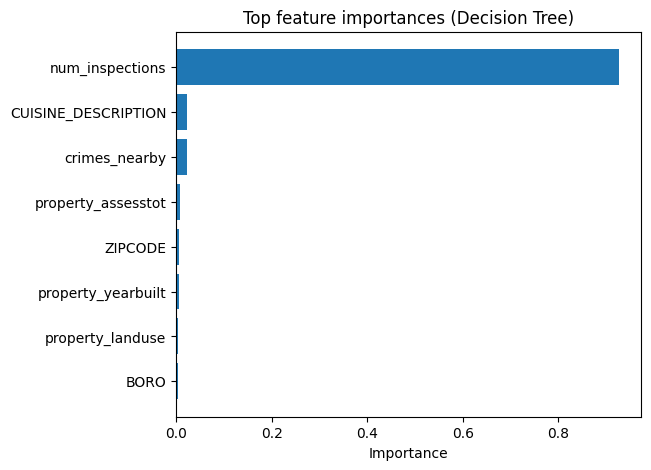

In [15]:
top_k = 15
top_importances = importances_sorted.head(top_k)

plt.figure(figsize=(6, 5))
plt.barh(top_importances["feature"], top_importances["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top feature importances (Decision Tree)")
plt.show()


looking at this model, it seems like number of inspections are the dominent factor in predicting the the inspection score

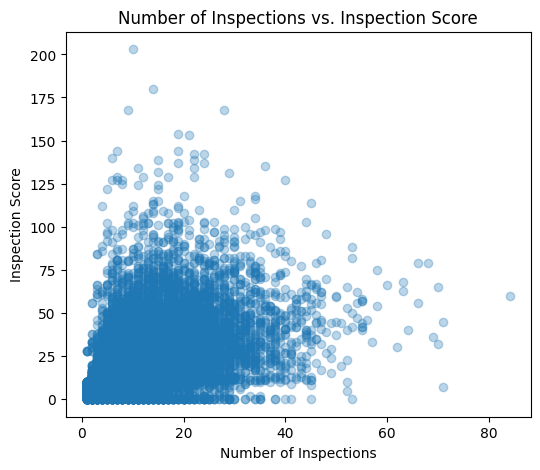

In [42]:
master = pd.read_csv("../data/processed/master_restaurant_dataset.csv")
plt.figure(figsize=(6,5))
plt.scatter(master["num_inspections"], master["last_score"], alpha=0.3)
plt.xlabel("Number of Inspections")
plt.ylabel("Inspection Score")
plt.title("Number of Inspections vs. Inspection Score")
plt.show()

This is a good finding but since num_inspections is part of how DOHMH manages restaurants,
it is not an external context factor like crime or property. To see how
well we can predict inspection scores using only context variables, we can fit
a second decision tree that excludes `num_inspections` from the inputs.

### Model without `num_inspections`:

In [26]:
from sklearn.model_selection import train_test_split

context_cols = [
    "BORO",
    "ZIPCODE",
    "CUISINE_DESCRIPTION",
    "crimes_nearby",
    "property_yearbuilt",
    "property_assesstot",
    "property_landuse",
]

X_context = master[context_cols].copy()
y_context = master["last_score"].copy()

# Re-apply the same encoding as before
Xc = X_context.copy()
for col in ["BORO", "CUISINE_DESCRIPTION", "property_landuse"]:
    Xc[col] = Xc[col].astype("category").cat.codes

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, y_context, test_size=0.2, random_state=42
)

mask_train = ~yc_train.isna()
Xc_train = Xc_train[mask_train].copy()
yc_train = yc_train[mask_train].copy()

mask_test = ~yc_test.isna()
Xc_test = Xc_test[mask_test].copy()
yc_test = yc_test[mask_test].copy()


tree_context = DecisionTreeRegressor(
    max_depth=6,
    random_state=42,
)

tree_context.fit(Xc_train, yc_train)
yc_pred = tree_context.predict(Xc_test)

tree_context_mse = mean_squared_error(yc_test, yc_pred)
tree_context_r2 = r2_score(yc_test, yc_pred)

tree_context_mse, tree_context_r2


(252.85044038058763, 0.009087640566138422)

In [28]:
importances_ctx = pd.DataFrame({
    "feature": Xc_train.columns,
    "importance": tree_context.feature_importances_,
})

importances_ctx_sorted = importances_ctx.sort_values(
    "importance", ascending=False
)

importances_ctx_sorted.head(10)


,feature,importance
5,property_assesstot,0.337704
2,CUISINE_DESCRIPTION,0.297959
1,ZIPCODE,0.150492
3,crimes_nearby,0.136071
4,property_yearbuilt,0.068714
0,BORO,0.004703
6,property_landuse,0.004358


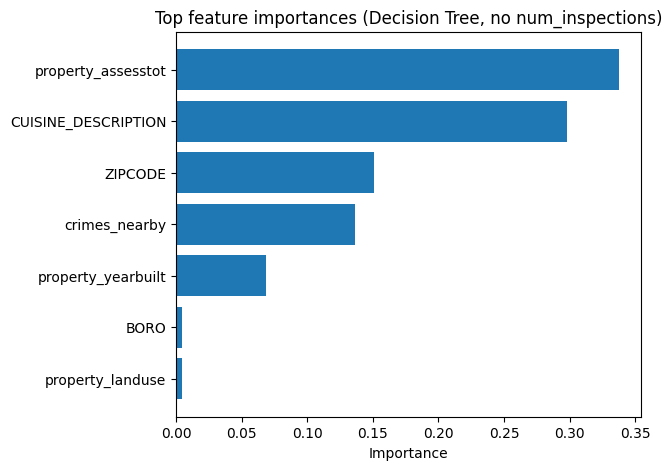

In [29]:
plt.figure(figsize=(6, 5))
top_ctx = importances_ctx_sorted.head(10)
plt.barh(top_ctx["feature"], top_ctx["importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top feature importances (Decision Tree, no num_inspections)")
plt.show()


We can compare three models on the held-out test set: a baseline that always
predicts the mean score, a decision tree that uses all features, and a
context-only tree that excludes `num_inspections`. Lower MSE and higher
R² indicate better performance.

In [32]:
results = pd.DataFrame({
    "model": [
        "Baseline (mean)",
        "DecisionTree (all features)",
        "DecisionTree (no num_inspections)",
    ],
    "MSE": [baseline_mse, tree_mse, tree_context_mse],
    "R2":  [baseline_r2,  tree_r2,  tree_context_r2],
})

results

,model,MSE,R2
0,Baseline (mean),255.179634,-0.000040
1,DecisionTree (all features),192.066496,0.247298
2,DecisionTree (no num_inspections),252.850440,0.009088


### Predicted vs actual scores

This plot shows how the context-only model’s predictions compare to the
true inspection scores on the test set. Points near the 45-degree line
are predicted well; points far away are predicted poorly.


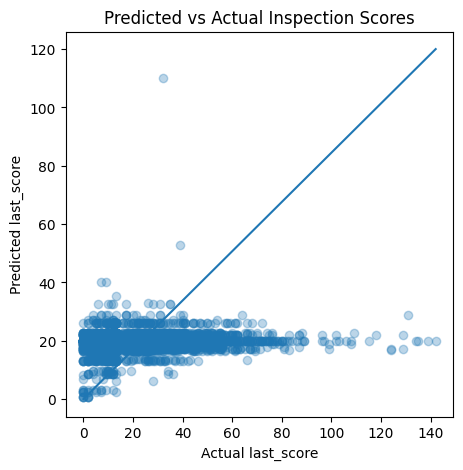

In [41]:
plt.figure(figsize=(5, 5))
plt.scatter(yc_test, yc_pred, alpha=0.3)
plt.xlabel("Actual last_score")
plt.ylabel("Predicted last_score")
plt.title("Predicted vs Actual Inspection Scores")

min_val = min(yc_test.min(), yc_pred.min())
max_val = max(yc_test.max(), yc_pred.max())
plt.plot([min_val, max_val], [min_val, 120])
plt.show()
